In [30]:
import os
import numpy as np
import cv2
import torch
import h5py
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines

# Load an image from the Hypersim dataset
image_path = '../assets/data/ai_001_009/ai_001_009/images/scene_cam_00_final_preview/frame.0001.color.jpg'
img = cv2.imread(image_path)[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Load depth and normal maps
depth_path = '../assets/data/ai_001_009/ai_001_009/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5'
normal_path = '../assets/data/ai_001_009/ai_001_009/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5'
position_path = '../assets/data/ai_001_009/ai_001_009/images/scene_cam_00_geometry_hdf5/frame.0001.position.hdf5'

with h5py.File(depth_path, 'r') as f:
    depth_map = np.array(f['dataset'])
with h5py.File(normal_path, 'r') as f:
    normal_map = np.array(f['dataset'])
with h5py.File(position_path, "r") as f:
    world_coordinates = np.array(f["dataset"])

depth_map = depth_map.astype(np.float32)
normal_map = normal_map.astype(np.float32)
world_coordinates = world_coordinates.astype(np.float32)

# Initialize DeepLSD model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {'detect_lines': True, 'line_detection_params': {'merge': False, 'filtering': True, 'grad_thresh': 3}}
ckpt = torch.load('../weights/deeplsd_md.tar', map_location='cpu', weights_only=False)
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

# Detect lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float32, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]


/var/folders/qb/d4hwnh6j08gd2t6xyjf8s4j00000gn/T/ipykernel_83283/1623177459.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))


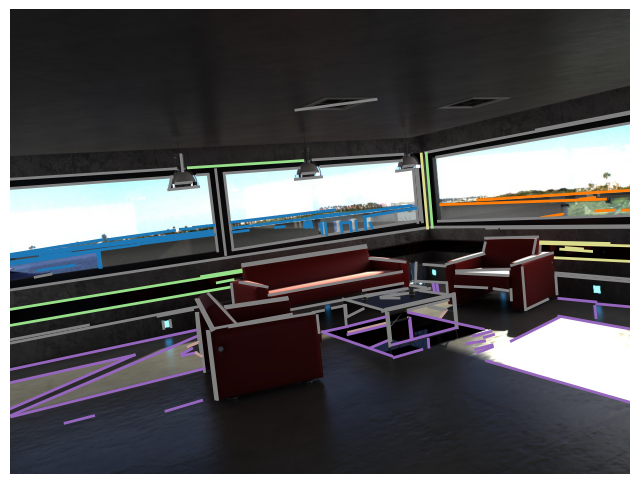

In [31]:

import numpy as np
import scipy.spatial.distance as dist


def mahalanobis_outlier_removal(normals, threshold=3.0):
    normals = np.array(normals)

    if normals.shape[0] < 3:  # Not enough data points
        return normals

    mean = np.mean(normals, axis=0)
    cov_matrix = np.cov(normals.T)

    # Regularization to avoid singular matrix
    cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6

    # Use pseudo-inverse if still singular
    try:
        inv_cov_matrix = np.linalg.inv(cov_matrix)
    except np.linalg.LinAlgError:
        inv_cov_matrix = np.linalg.pinv(cov_matrix)

    distances = np.array([dist.mahalanobis(n, mean, inv_cov_matrix) for n in normals])
    return normals[distances < threshold]

def compute_average_plane(points, normals):
    """
    Compute an average plane equation ax + by + cz + d = 0 
    for a set of 3D points and their corresponding normal vectors.

    Parameters:
    
    points (np.ndarray): Nx3 array of 3D points along a line.
    normals (np.ndarray): Nx3 array of normal vectors at each point.

        Returns:
        
    np.ndarray: Plane equation coefficients [a, b, c, d]."""
    if len(points) < 3:
        return None  # Not enough points to define a plane
    
    filtered_normals_dbscan = mahalanobis_outlier_removal(normals, threshold=1.5) #thickness2: eps=0.2, thickness3: eps=0.5

    # Compute the average normal vector
    avg_normal = np.mean(filtered_normals_dbscan, axis=0)
    avg_normal /= np.linalg.norm(avg_normal)  # Normalize it

    # Compute the average point on the line
    avg_point = np.mean(points, axis=0)

    # Compute d using the plane equation formula: ax + by + cz + d = 0
    a, b, c = avg_normal
    d = -np.dot(avg_normal, avg_point)

    return np.array([a, b, c, d])  # Return plane coefficients
def get_line_pixels(line, maps):
    """
    Get all pixel coordinates along a line using cv2.line.
    """
    x1, y1 = map(int, line[0])
    x2, y2 = map(int, line[1])
    height, width = maps.shape[:2]

    blank_image = np.zeros((height, width), dtype=np.uint8)
    cv2.line(blank_image, (x1, y1), (x2, y2), color=255, thickness=3)
    
    y_coords, x_coords = np.where(blank_image == 255)
    return list(zip(x_coords, y_coords))

def extract_line_features(lines, normal_map, world_coordinates):
    """
    Extract spatial and normal features for each line.
    """
    line_features = []
    for line in lines:
        pixel_coords = get_line_pixels(line, depth_map)

        points, normals = [], []
        for x, y in pixel_coords:
            points.append(world_coordinates[y, x])
            normals.append(normal_map[y, x])

        if len(points) > 2:
            plane = compute_average_plane(np.array(points), np.array(normals))
            if plane is not None:
                line_features.append(plane)

    return np.array(line_features, dtype=object)

def cluster_coplanar_lines(line_features, eps=0.5, min_samples=5):
    """
    Cluster coplanar lines using DBSCAN.
    """
    if len(line_features) == 0:
        return []

    # Feature vector: (plane normal x, y, z, centroid x, y, z)
    # feature_matrix = np.array([np.hstack((plane[:3], centroid)) for plane, centroid, _ in line_features])
    feature_matrix = line_features
    # DBSCAN Clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(feature_matrix)
    return clustering.labels_

# Extract features
line_features = extract_line_features(pred_lines, normal_map, world_coordinates)

# Apply DBSCAN
coplanar_clusters = cluster_coplanar_lines(line_features, min_samples=4, eps=0.2) #thickness2: eps=0.6, thickness3: eps=0.2 

# Visualization Function
def plot_coplanar_lines(lines, labels, image):
    unique_labels = set(labels)
    colors = plt.cm.get_cmap("tab20", len(unique_labels))

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    for idx, line in enumerate(lines):
        label = labels[idx]
        if label == -1:  # Outliers
            color = 'grey'
        else:
            color = colors(label)[:3]  # Get unique color

        plt.plot([line[0, 0], line[1, 0]], [line[0, 1], line[1, 1]], color=color, linewidth=2)
    plt.axis("off")
    plt.show()

# Plot results
plot_coplanar_lines(pred_lines, coplanar_clusters, img)